This is a example of two dof Duffing oscillator based on the paper:

[A SIMPLE CRITERION FOR ESTABLISHING AN UPPER LIMIT TO THE HARMONIC EXCITATION LEVEL OF THE DUFFING OSCILLATOR USING THE VOLTERRA SERIES](https://www.sciencedirect.com/science/article/pii/S0022460X96900917)

The following nonlinear equation of motion is solve:

$$
\begin{align}
m_1 \ddot{x}_1 + 2 c \dot{x}_1 - c \dot{x}_2 + 2 k_1 x_1 - k_1 x_2 - \beta(x_2 - x_1)^3   & = P cos( \omega t) \\
m_2 \ddot{x}_2 + 2 c \dot{x}_2 - c \dot{x}_1 + 2 k_1 x_2 - k_1 x_1 + \beta(x_2 - x_1)^3   & = 0
\end{align}
$$

Where $m_1 = m_2 = 1 kg$, $c = 10 Ns/m $  , $k_1 = 10^4 N/m$ and $k_3 = 10^{10} N/m^3$ 

Rewritten the two above equation in matrix notation we get:

\begin{equation*}
\begin{bmatrix}
m_1 & 0 \\
0 & m_2 
\end{bmatrix}
\begin{bmatrix}
\ddot{x}_1 \\
\ddot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
2c & -c \\
-c & 2c 
\end{bmatrix}
\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix}
+
\begin{bmatrix}
2k_1 & -k_1 \\
-k_1 & 2k_1 
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
+
\begin{bmatrix}
f^{NL}_1(x_1,x_2) \\
f^{NL}_2(x_1,x_2)
\end{bmatrix}
=
\begin{bmatrix}
P cos( \omega t) \\
0
\end{bmatrix}
\end{equation*}

Where $f^{NL}_1(x_1,x_2)= -\beta (x_2 - x_1)^3$ and $f^{NL}_2(x_1,x_2)= \beta (x_2 - x_1)^3$ 

In compact matrix notation notation we have:

$$
M \ddot{x} + C \dot{x} + K x + f^{NL}(x) = f^L
$$

Where $f^L$ is the vector function $ [ P cos( \omega t), 0 ]^T $ and $f^{NL}(x)$ is defined as:

$$
f^{NL}(x) = \beta (H  B^{\Delta} x)^3
$$ 

where $H$ is the matrix:
\begin{equation*}
H = 
\begin{bmatrix}
-1 & 0 \\
0 & 1
\end{bmatrix}
\end{equation*}

and $B^{\Delta}$ is 

\begin{equation*}
B^{\Delta} = 
\begin{bmatrix}
-1 & 1 \\
-1 & 1
\end{bmatrix}
\end{equation*}


If we apply a Fourier Transform $\mathscr{F}$ in the above system we have:
$$
Z( \omega ) \tilde{x} + \tilde{f}^{NL} (\tilde{x}) - \tilde{f}^L = 0
$$

where 
$$
Z( \omega ) = -\omega^2 M + j \omega C + K
$$

$$
\tilde{f}^L = [P,0]^T
$$

$$
\tilde{f}^{NL}(\tilde{x}) = \mathscr{F}(f^{NL}(\mathscr{F}^{-1}(\tilde{x})))
$$

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


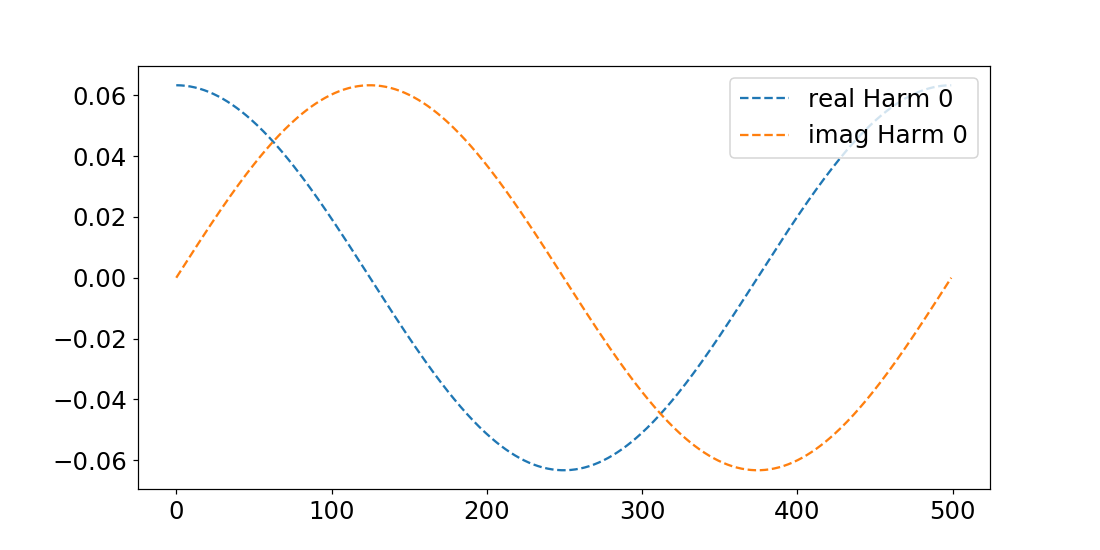

In [1]:
%matplotlib notebook
import numpy as np
from scipy import sparse, linalg
import matplotlib.pyplot as plt
from scipy.misc import derivative
#from scipy import optimize
import sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from amfe.frequency_module.frequency import cos_bases_for_MHBM, create_Z_matrix, linear_harmonic_force, hbm_complex_bases
from amfe.operators.operators import ReshapeOperator
from amfe.optimize import optimize
from ipywidgets import interact
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation


plt.rcParams.update({'font.size': 16})


#B = cos_bases_for_MHBM(1,number_of_harm=1,static=False)
nH = 1
n_points = 500
q = hbm_complex_bases(1,number_of_harm=nH,n_points=n_points,static=False,normalized=False)

fig = plt.figure(figsize=(10,5))
for i in range(q.shape[1]):
#for i in range(2):
    plt.plot(q[:,i].real,'--',label='real Harm ' + str(i))
    plt.plot(q[:,i].imag,'--',label='imag Harm ' + str(i))
 
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


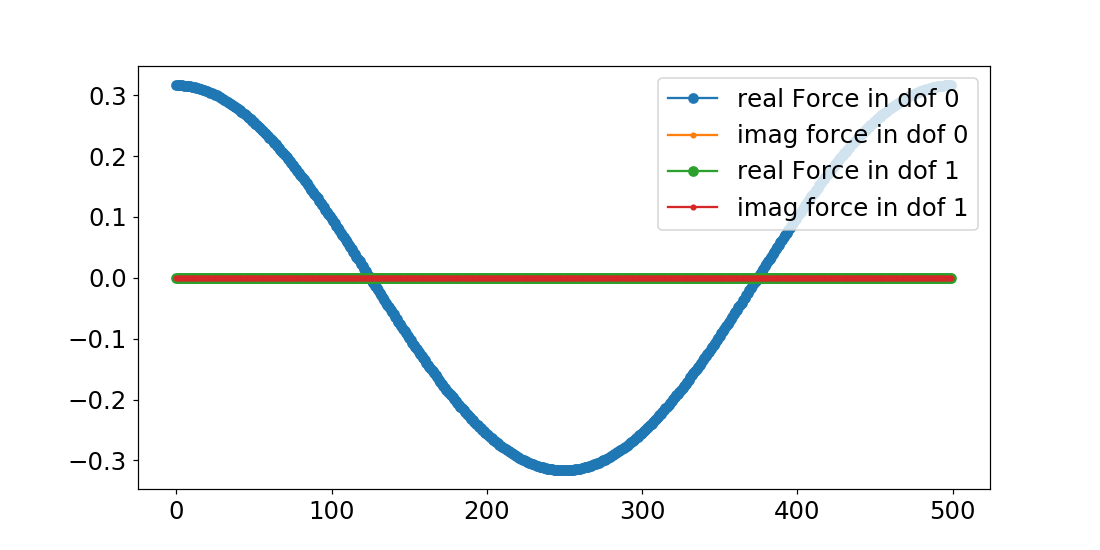

In [2]:
amplitude_dof_1 = 5.0
amplitude_dof_2 = 0.0
P = np.array([amplitude_dof_1, amplitude_dof_2], dtype = np.complex)
beta = 5.0
m1 = 1.0
m2 = m1
k1 = 1.0
k2 = k1
c1 = 0.05
c2 = c1



K = np.array([[k1+k2, -k2],
              [-k2,k2+k1]])

M = np.array([[m1,0.0],
              [0.0,m2]])

C = np.array([[c1+c2,-c2],
              [-c2,c1+c2]])

B_delta = np.array([[-1, 1],
                    [-1, 1]])

H = np.array([[-1, 0],
              [ 0, 1]])

n_dofs = K.shape[0] 
Ro = ReshapeOperator(n_dofs,n_points)


I = np.eye(n_dofs)
I_harm = np.eye(nH)
#Q = np.kron(q ,[1]*nH)
Q = np.kron(I,q[:,0])
for i in range(1,nH):
    Q = np.concatenate([Q,np.kron(I,q[:,i])])
Q = Q.T
Tc = H.dot(B_delta)

P_aug = list(0*P)*nH
P_aug[0:n_dofs] = list(P)
P_aug = np.array(P_aug)
fl = Q.dot(P_aug).real

        
fig = plt.figure(figsize=(10,5))
for i in range(int(fl.shape[0]/n_points)):
    plt.plot(fl[i*n_points:(i+1)*n_points].real,'o-',label='real Force in dof ' + str(i))
    plt.plot(fl[i*n_points:(i+1)*n_points].imag,'.-',label='imag force in dof ' + str(i))
 
plt.legend(loc='upper right')
plt.show()

In [3]:
Q.shape

(1000, 2)

In [4]:
fl = Q.dot(P_aug).real
fl_ = Q.conj().T.dot(fl) # force in frequency domain
fnl = lambda u : beta*(Tc.dot(u)**3)
fnl_ = lambda u_ : Q.conj().T.dot(Ro.T.dot(fnl(Ro.dot(Q.dot(u_).real)))) - fl_
Z = lambda w : create_Z_matrix(K,C,M,f0= w/(2.0*np.pi),nH=nH, static=False)
R = lambda u_, w : Z(w).dot(u_) + fnl_(u_)


In [5]:
%%time
x0 = np.array([0.0]*n_dofs*nH,dtype=np.complex)
y_d, p_d, info_dict = optimize.continuation(R,x0=x0,p_range=(0.01,3.0), p0=0.1, max_int=300, 
                                            max_dp=0.05,step=0.05, max_int_corr=20, tol=1.0E-10)

print('Applied divided by calculated amplitude, must be close to 1.0')
print(P.real/fl_[:n_dofs].real)
y_d = y_d/P.max().real

Applied divided by calculated amplitude, must be close to 1.0
[0.99800399        nan]
Wall time: 53.7 s


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
P.max().real

In [ ]:
dof_id = 0

fig, ax1 = plt.subplots(1)
max_x = np.abs(p_d).max()
min_x = np.abs(p_d).min()
max_y = np.abs(y_d[dof_id]).max()
min_y = np.abs(y_d[dof_id]).min()

factor = 0.1
lim = lambda x, factor  : x + np.sign(x)*factor*x

ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])


def update(i):
    ax1.clear()
    ax1.plot(p_d[i],np.abs(y_d[dof_id][i]),'ro',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[dof_id][:i]),'k.')
    ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
    ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])
    ax1.set_xlabel('Frequency [rad/s]', fontsize=12)
    ax1.set_ylabel('Normalized Amplitude', fontsize=12)
    ax1.set_title('2 dofs Couple Duffing Oscillator with %i Harmonics and %i time samples' %(nH,n_points), fontsize=12)
    #ax1.plot(p_d[i],y_d[0][i],'bo')
    
ani = FuncAnimation(fig, update, frames=np.arange(0, len(p_d) ,5 ), blit=True, interval=10)   

if False:
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=30, metadata=dict(artist='Guilherme Jenovencio'), bitrate=1800)

    ani.save('2dof_couple_duffing_ocsillator_v1.gif', dpi=200, writer=writer)

In [ ]:
p = np.linspace(0.01,4,500)
Ru = lambda f : lambda u_ : R(u_,f)
#x0 = np.array([0],dtype=np.complex)
x0 = np.array([0]*n_dofs*nH,dtype=np.complex)
x_list = []
f_list = []
for f in p:
    opt_obj = optimize.root(Ru(f),x0=x0,tol=1.0E-12)
    x_opt = opt_obj.x
    #x0 = x_opt
    if opt_obj.success:
        x_list.append(x_opt)
        f_list.append(f)
    

In [ ]:
plt.figure()
plt.plot(f_list, np.abs(x_list),'o')

In [ ]:
plt.figure()
plt.plot(p_d.real)
plt.plot(p_d.imag)

In [ ]:
val, vec = linalg.eig(K,M)

In [ ]:
np.sqrt(1/val)

In [ ]:
P

In [ ]:
P.real/fl_[:n_dofs].real

In [ ]:
min(P.real/fl_[:n_dofs].real)

In [ ]:
P.real/fl_[:n_dofs].real

In [ ]:
y_d[0].shape

In [ ]:
p_d.shape

In [ ]:
y_d.T[0].shape

In [ ]:
Q.shape

In [ ]:
def built_disp_hist_based_on_freq_id(freq_id):
    #print('Frequency in rad/s = %f' %p_d[freq_id].real)
    u = Ro.dot(Q.dot(y_d.T[freq_id])).real
    f = Ro.dot(Q.dot(P_aug)).real
    return u,f

In [ ]:
u,f = built_disp_hist_based_on_freq_id(2600)

In [ ]:
plt.figure()
plt.plot(u.T)
plt.show()

In [ ]:
plt.figure()
plt.plot(f.T)
plt.show()

In [ ]:
dof_id = 0

fig1, (ax1,ax2) = plt.subplots(2, figsize=(10,10))
max_x = np.abs(p_d).max()
min_x = np.abs(p_d).min()
max_y = np.abs(y_d[dof_id]).max()
min_y = np.abs(y_d[dof_id]).min()

factor = 0.1
lim = lambda x, factor  : x + np.sign(x)*factor*x

ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])


def update2(i):
    ax1.clear()
    ax1.plot(p_d[i],np.abs(y_d[0][i]),'ro',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[0][:i]),'k-',label='dof 1')
    ax1.plot(p_d[i],np.abs(y_d[1][i]),'bo',markerfacecolor='y')
    ax1.plot(p_d[:i],np.abs(y_d[1][:i]),'r-', label='dof 2')
    ax1.set_xlim([lim(min_x,-factor)   ,lim(max_x,factor)])
    ax1.set_ylim([lim(min_y,-factor)   ,lim(max_y,factor)])
    ax1.set_xlabel('Frequency [rad/s]', fontsize=12)
    ax1.set_ylabel('Normalized Amplitude', fontsize=12)
    ax1.set_title('2 dofs Couple Duffing Oscillator with %i Harmonics and %i time samples' %(nH,n_points), fontsize=12)
    ax1.legend()
    
    u,f = built_disp_hist_based_on_freq_id(i)
    ax2.clear()
    ax2.plot(u.T[0],'k-',label='dof 1')
    ax2.plot(u.T[1],'r-', label='dof 2')
    ax2.set_xlabel('Time sample', fontsize=12)
    ax2.set_ylabel('Amplitude [mm]', fontsize=12)
    
    ax2.set_ylim([-0.5   ,0.5])
    ax2.set_xlim([0   ,1000])
    ax2.legend()
    #ax1.plot(p_d[i],y_d[0][i],'bo')
    
ani = FuncAnimation(fig1, update2, frames=np.arange(0, len(p_d) ,10 ), blit=True, interval=1)   

if False:
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=30, metadata=dict(artist='Guilherme Jenovencio'), bitrate=1000)#
    ani.save('2dof_couple_duffing_ocsillator_v5.gif', dpi=200, writer=writer)